In [1]:
import sys
sys.path.append('C:\\Users\\Yonatan Gideoni\\Desktop\\ML4Q\\c3')

Code mostly taken from <code>two_qubits.ipynb</code>

#### Imports

In [2]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from pprint import pprint

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.hamiltonians as hamiltonians
import c3.libraries.fidelities as fidelities
import c3.libraries.envelopes as envelopes
import c3.utils.qt_utils as qt_utils
import c3.utils.tf_utils as tf_utils

# Qiskit related modules
from c3.qiskit import C3Provider
from c3.qiskit.c3_gates import RX90pGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.tools.visualization import plot_histogram

#### Model components

In [3]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -210e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq_q1,
        min_val=4.995e9 ,
        max_val=5.005e9 ,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q1,
        min_val=-380e6 ,
        max_val=-120e6 ,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q1,
        min_val=1e-6,
        max_val=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q1,
        min_val=10e-6,
        max_val=90e-3,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min_val=0.0,
        max_val=0.12,
        unit='K'
    )
)

In [4]:
drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)

The following task creates an initial thermal state with given temperature.

In [5]:
init_temp = 50e-3
init_ground = tasks.InitialiseGround(
    init_temp=Qty(
        value=init_temp,
        min_val=-0.001,
        max_val=0.22,
        unit='K'
    )
)

We collect the parts specified above in the Model.

In [6]:
model = Mdl(
    [q1], # Individual, self-contained components
    [drive],  # Interactions between components
)

Further, we can decide between coherent or open-system dynamics using set_lindbladian() and whether to eliminate the static coupling by going to the dressed frame with set_dressed().

In [7]:
model.set_lindbladian(False)
model.set_dressed(True)

#### Control signals

In [8]:
sim_res = 100e9 # Resolution for numerical simulation
awg_res = 2e9 # Realistic, limited resolution of an AWG
lo = devices.LO(name='lo', resolution=sim_res)
awg = devices.AWG(name='awg', resolution=awg_res)
mixer = devices.Mixer(name='mixer')

In [9]:
dig_to_an = devices.DigitalToAnalog(
    name="dac",
    resolution=sim_res
)
v2hz = 1e9
v_to_hz = devices.VoltsToHertz(
    name='v_to_hz',
    V_to_Hz=Qty(
        value=v2hz,
        min_val=0.9e9,
        max_val=1.1e9,
        unit='Hz/V'
    )
)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [10]:
generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": devices.AWG(name='awg', resolution=awg_res, outputs=1),
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=1e9,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "d1": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
            "d2": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            },
        }
    )

Optionally, we can look at the signal generated by each device by setting a callback.

In [11]:
generator.callback = lambda chain_id, device_id, signal: (
    # do something
)

#### Gates-set and Parameter map

In [12]:
t_final = 7e-9   # Time for single qubit gates
sideband = 50e6 

In [13]:
def_params = {
    'amp': Qty(
        value=0.26,
        min_val=0.0,
        max_val=100,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=-sideband - 3e6 ,
        min_val=-56 * 1e6 ,
        max_val=-52 * 1e6 ,
        unit='Hz 2pi'
    ),
    'delta': Qty(
        value=-1,
        min_val=-5,
        max_val=3,
        unit=""
    )
}

In [14]:
# gaussiam params
gauss_params = copy.deepcopy(def_params)
gauss_params['sigma'] = Qty(
    value=t_final / 4, 
    min_val=t_final / 8, 
    max_val=t_final / 2, 
    unit="s"
)

gauss_env = pulse.Envelope(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params,
    shape=envelopes.gaussian_nonorm,
    normalize_pulse=True
)

In [15]:
# hann params
hann_params = copy.deepcopy(def_params)
hann_env = pulse.Envelope(
    name="hann",
    desc="Hann comp for single-qubit gates",
    params=hann_params,
    shape=envelopes.hann,
    normalize_pulse=True
)

In [16]:
# blackman params
blackman_params = copy.deepcopy(def_params)

blackman_env = pulse.Envelope(
    name="blackman",
    desc="Blackman comp for single-qubit gates",
    params=blackman_params,
    shape=envelopes.blackman_window,
    normalize_pulse=True
)

In [17]:
signal_type_config = {
    'gauss': (gauss_params, gauss_env), 
    'hann': (hann_params, hann_env),
    'blackman': (blackman_params, blackman_env)
}
opt_params_per_sig =  {
    'gauss': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'hann': ['amp', 'freq_offset', 'xy_angle', 'delta'],
    'blackman': ['amp', 'freq_offset', 'xy_angle', 'delta']
}

In [18]:
n_pulses_per_type = {'gauss': 3, 'hann': 3, 'blackman': 3}

largest_pulse_v = 0.3
smallest_pulse_v = 0.16

signal_envelopes = []
signals_opt_params = []

for pulse_type, n_pulses in n_pulses_per_type.items():
    for i, voltage in enumerate(np.linspace(smallest_pulse_v, largest_pulse_v, n_pulses)):
        def_params, def_env = signal_type_config[pulse_type]
        pulse_params = copy.deepcopy(def_params)
        pulse_params['amp'].set_value(voltage)
        
        envelope = copy.deepcopy(def_env)
        envelope.params = pulse_params
        signals_opt_params.append(opt_params_per_sig[envelope.name])
        envelope.name += str(i)
        signal_envelopes.append(envelope)

In [19]:
lo_freq_q1 = 5e9  + sideband
carrier_parameters = {
    'freq': Qty(
        value=lo_freq_q1,
        min_val=4.5e9 ,
        max_val=6e9 ,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min_val= -np.pi,
        max_val= 3 * np.pi,
        unit='rad'
    )
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters
)

#### Instructions

In [20]:
rx90p_q1 = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final, channels=["d1"]
)

rx90p_q1.add_component(carr, "d1")

for envelope in signal_envelopes:
    rx90p_q1.add_component(envelope, "d1")

When later compiling gates into sequences, we have to take care of the relative rotating frames of the qubits and local oscillators. We do this by adding a phase after each gate that realigns the frames.

In [21]:
######### Plot the control signals #############

def plot_controls(pmap, prefactor):
    for gate, instruction in pmap.instructions.items():
        fig, ax = plt.subplots(1)
        ax.set_title(gate.replace("_", "-"))
        legend = []
        counter = 0
        for chan, channel in instruction.comps.items():
            amp = prefactor[counter]
            counter += 1
            for com, component in channel.items():
                if "t_final" in component.params:
                    t_final = component.params["t_final"].get_value()
                    ts = np.linspace(0, t_final, 1001)
                    shape = amp * component.get_shape_values(ts)
                    ax.plot(ts[:len(shape)]/1e-9, shape)
                    legend.append((chan, com.replace("_", "-")))
        ax.set_xlabel("Time [ns]")
#         ax.set_ylabel("Amplitude")
        ax.set_ylabel("Amplitude [normalized]")
        ax.legend(legend)

The remainder of the gates-set can be derived from the RX90p gate by shifting its phase by multiples of $\pi/2$.

In [22]:
single_q_gates = [rx90p_q1]

In [23]:
rx90p_q1.comps["d1"]

{'carrier': carrier:: freq : 5.050 GHz 2pi , framechange : 0.000 rad , ,
 'gauss0': gauss0:: amp : 160.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, ,
 'gauss1': gauss1:: amp : 230.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, ,
 'gauss2': gauss2:: amp : 300.000 mV , t_final : 7.000 ns , xy_angle : -444.089 arad , freq_offset : -53.000 MHz 2pi , delta : -1.000  , sigma : 1.750 ns , shape: gaussian_nonorm, }

With every component defined, we collect them in the parameter map, our object that holds information and methods to manipulate and examine model and control parameters.

In [24]:
parameter_map = PMap(instructions=single_q_gates, model=model, generator=generator)

#### The experiment

In [25]:
exp = Exp(pmap=parameter_map)

#### Simulation

In [26]:
exp.set_opt_gates(['rx90p[0]'])
unitaries = exp.compute_propagators()

### Dynamics

In [27]:
psi_init = [[0] * 3]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

In [28]:
init_state

<tf.Tensor: shape=(3, 1), dtype=complex128, numpy=
array([[1.+0.j],
       [0.+0.j],
       [0.+0.j]])>

In [29]:
gate_seq = ['rx90p[0]']

Plotting system dynamics:

In [30]:
def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        exp.compute_propagators()
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

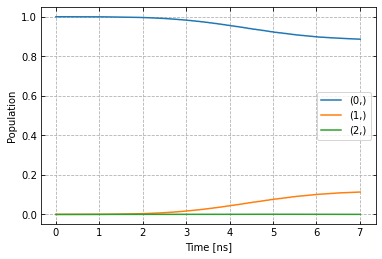

In [31]:
plot_dynamics(exp, init_state, gate_seq)

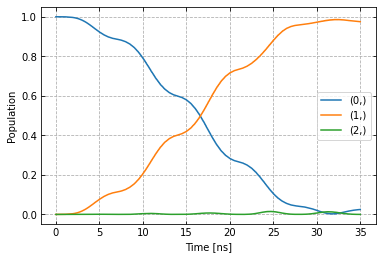

In [32]:
plot_dynamics(exp, init_state, gate_seq * 5)

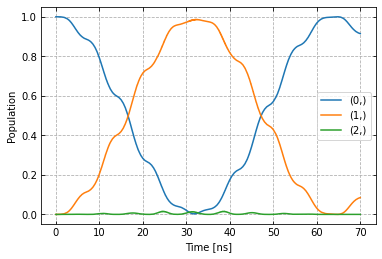

In [33]:
plot_dynamics(exp, init_state, gate_seq * 10)

Note that at this point, we only multiply already computed matrices. We don't need to solve the equations of motion again for new sequences.

#### Visualisation with qiskit circuit of Rx90p

In [34]:
qc = QuantumCircuit(1)
qc.append(RX90pGate(), [0])
qc.draw()

┌────────────┐
q: ┤ Rx90p(π/2) ├
   └────────────┘

In [35]:
c3_provider = C3Provider()
c3_backend = c3_provider.get_backend("c3_qasm_physics_simulator")
c3_backend.set_c3_experiment(exp)

In [36]:
c3_job_unopt = c3_backend.run(qc)
result_unopt = c3_job_unopt.result()
res_pops_unopt = result_unopt.data()["state_pops"]
print("Result from unoptimized gates:") 
pprint(res_pops_unopt)

Result from unoptimized gates:
{'(0,)': 0.8864647138704549,
 '(1,)': 0.11324409828071134,
 '(2,)': 0.00029118784883469865}


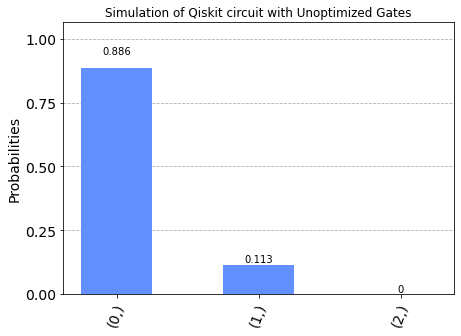

In [37]:
plot_histogram(res_pops_unopt, title='Simulation of Qiskit circuit with Unoptimized Gates')

To define which parameters we optimize, we write the gateset_opt_map, a nested list of tuples that identifies each parameter.

In [38]:
opt_gates = ["rx90p[0]"]
gateset_opt_map = [[("rx90p[0]", "d1", "carrier", "framechange"),]]
for envelope, sig_opt_params in zip(signal_envelopes, signals_opt_params):
    sig_name = envelope.name
    for param in sig_opt_params:
        gateset_opt_map.append([("rx90p[0]", "d1", sig_name, param),])

parameter_map.set_opt_map(gateset_opt_map)

In [39]:
parameter_map.print_parameters()

rx90p[0]-d1-carrier-framechange       : 0.000 rad 
rx90p[0]-d1-gauss0-amp                : 160.000 mV 
rx90p[0]-d1-gauss0-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss0-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss0-delta              : -1.000  
rx90p[0]-d1-gauss1-amp                : 230.000 mV 
rx90p[0]-d1-gauss1-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss1-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss1-delta              : -1.000  
rx90p[0]-d1-gauss2-amp                : 300.000 mV 
rx90p[0]-d1-gauss2-freq_offset        : -53.000 MHz 2pi 
rx90p[0]-d1-gauss2-xy_angle           : -444.089 arad 
rx90p[0]-d1-gauss2-delta              : -1.000  



In [40]:
from c3.optimizers.optimalcontrol import OptimalControl

In [41]:
import os
import tempfile

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")
fid_func = fidelities.sparse_unitary_infid_set,

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.sparse_unitary_infid_set,
    fid_subspace=["Q1"],
    pmap=parameter_map,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 1500},
    run_name="opt_multi_same_pulse"
)

In [42]:
exp.set_opt_gates(opt_gates)
opt.set_exp(exp)

In [43]:
opt.optimize_controls()

C3:STATUS:Saving as: C:\Users\YONATA~1\AppData\Local\Temp\tmp0i5tfjyp\c3logs\opt_multi_same_pulse\2022_08_03_T_15_13_04\open_loop.c3log


C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\utils\utils.py:64: UserWarning: OSError encountered while creating symlink
  warnings.warn("OSError encountered while creating symlink")
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss0-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss1-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(
C:\Users\Yonatan Gideoni\Desktop\ML4Q\c3\c3\optimizers\optimizer.py:296: Warning: rx90p[0]-d1-gauss2-delta has no gradient. This might indicate no usage for current experiment.
  warnings.warn(


In [44]:
opt.current_best_goal

0.00420176274125456

Results for same gate sequence as before post-optimization:

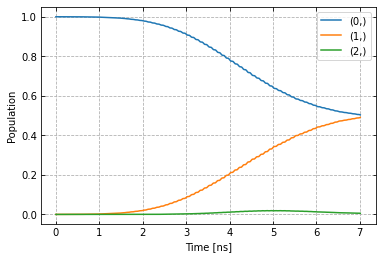

In [45]:
plot_dynamics(exp, init_state, gate_seq)

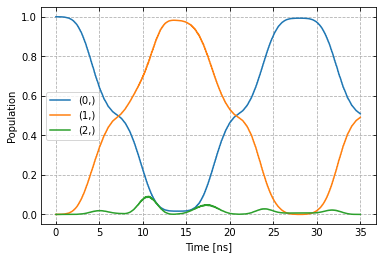

In [46]:
plot_dynamics(exp, init_state, gate_seq * 5)

Optimal parameters:

In [47]:
parameter_map.print_parameters()

rx90p[0]-d1-carrier-framechange       : 388.530 mrad 
rx90p[0]-d1-gauss0-amp                : 481.824 mV 
rx90p[0]-d1-gauss0-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss0-xy_angle           : -166.369 mrad 
rx90p[0]-d1-gauss0-delta              : -1.000  
rx90p[0]-d1-gauss1-amp                : 530.308 mV 
rx90p[0]-d1-gauss1-freq_offset        : -52.999 MHz 2pi 
rx90p[0]-d1-gauss1-xy_angle           : -193.711 mrad 
rx90p[0]-d1-gauss1-delta              : -1.000  
rx90p[0]-d1-gauss2-amp                : 582.825 mV 
rx90p[0]-d1-gauss2-freq_offset        : -52.997 MHz 2pi 
rx90p[0]-d1-gauss2-xy_angle           : -221.255 mrad 
rx90p[0]-d1-gauss2-delta              : -1.000  



In [48]:
parameter_map.get_parameter(['rx90p[0]','d1','gauss0','amp'])

481.824 mV